# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
!pip install gtts

  Using cached gTTS-2.5.3-py3-none-any.whl (29 kB)
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
# Import all the required libraries

import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from collections import Counter
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
from tqdm import tqdm
import time
from PIL import Image

from nltk.translate.bleu_score import sentence_bleu
from gtts import gTTS
from IPython.display import Audio
import tempfile

In [3]:
import tensorflow as tf

Let's read the dataset

## Data understanding
1. Import the dataset and read image & captions into two seperate variables

2. Visualise both the images & text present in the dataset

3. Create a dataframe which summarizes the image, path & captions as a dataframe

4. Create a list which contains all the captions & path

5. Visualise the top 30 occuring words in the captions



In [4]:
# Import the dataset and read the image into a seperate variable

images = 'datasets/flickr/Images'
text_file = "datasets/flickr/captions.txt"

# images = 'images'
# text_file = "filtered_captions.txt"

all_imgs = glob.glob(images + '/*.jpg', recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [5]:
# Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    """ Load the document into memory"""
    with open(filename) as file:
        text = file.read()

    return text



doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


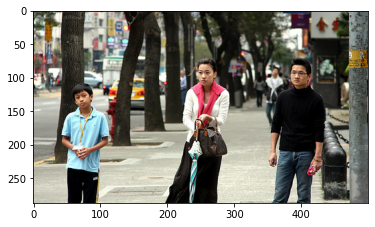

In [6]:
# Visualise both the images & text present in the dataset

def visualize_image(path):
    """
    Display an image from the specified file path.

    Parameters:
    path (str): The file path to the image to be displayed.

    Returns:
    None
    """
    # Read the image from the file path
    img = mpimg.imread(path)

    # Display the image
    imgplot = plt.imshow(img)

    # Show the image plot
    plt.show()


visualize_image(all_imgs[10])

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [7]:

captions_df = pd.read_csv(text_file)

In [8]:
captions_df[0:10]

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [9]:
# all_img_id = #store all the image id here
# all_img_vector = #store all the image path here
# annotations = #store all the captions here

# df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])

# df

df = captions_df.copy()
df['Path'] = df['image'].apply(lambda x: images + '/' + x)
df.rename(columns={'image': 'ID', 'caption': 'Captions'}, inplace=True)

all_img_id = df['ID'].values.tolist()
all_img_vector = df['Path'].values.tolist()
annotations = df['Captions'].values.tolist()

In [10]:
# Create a list which contains all the captions

# add the <start> & <end> token to all those captions as well

annotations = ['<start> ' + i + ' <end>' for i in annotations]


# Create a list which contains all the path to the images
all_img_path = all_img_vector  # write your code here

print("Total captions present in the dataset: " + str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [11]:
# Create the vocabulary & the counter for the captions

sentences_list = [annotation.split() for annotation in df.Captions.values]
vocabulary = [word for sentence in sentences_list for word in sentence]

counter = Counter(vocabulary)

print("The size of the vocabulary is: " + str(len(counter)))
print("The top 30 occuring words are: " + str(counter.most_common(30)))

The size of the vocabulary is: 9630
The top 30 occuring words are: [('a', 40319), ('.', 36577), ('A', 22667), ('in', 18962), ('the', 15328), ('on', 10730), ('is', 9345), ('and', 8850), ('dog', 7984), ('with', 7760), ('man', 6829), ('of', 6712), ('Two', 4365), ('white', 3876), ('black', 3696), ('are', 3503), ('boy', 3442), (',', 3232), ('woman', 3228), ('girl', 3218), ('to', 3173), ('The', 3089), ('wearing', 3061), ('at', 2904), ('water', 2778), ('red', 2660), ('brown', 2475), ('people', 2446), ('young', 2432), ('his', 2357)]


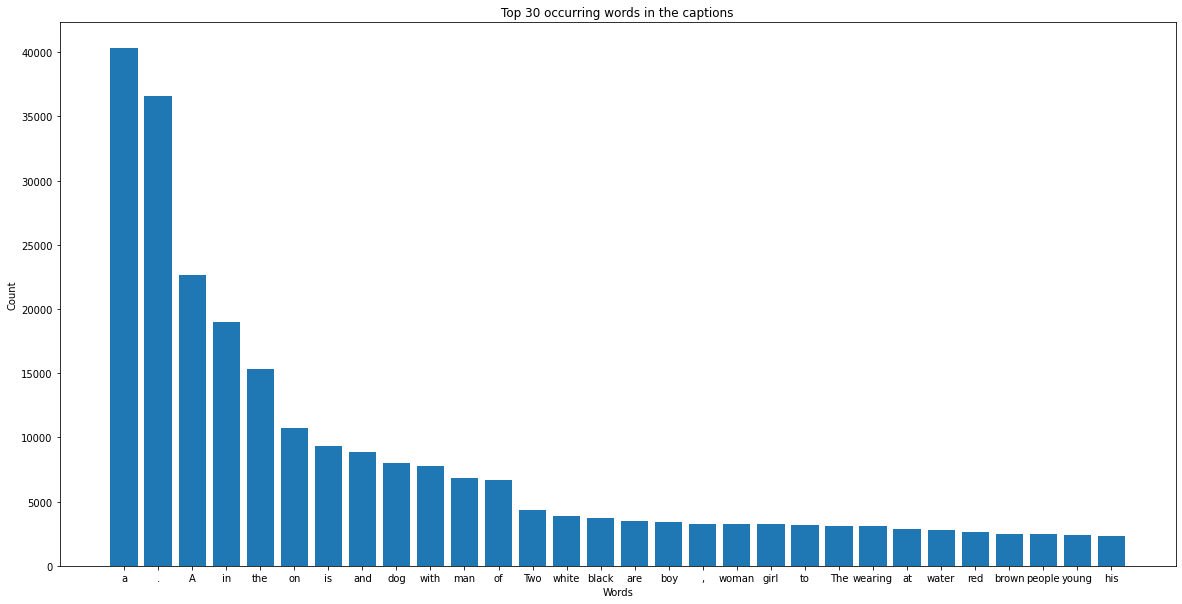

In [12]:
# Visualise the top 30 occuring words in the captions

def plot_top_words(counter: Counter, top_n: int = 30) -> None:
    """
    Plot a bar chart of the top N most common words in the captions.

    Parameters:
    counter (Counter): A Counter object containing word counts.
    top_n (int): The number of top words to display. Default is 30.

    Returns:
    None
    """
    # Sort the counter by count in descending order and get the top_n items
    most_common = counter.most_common(top_n)

    # Extract words and their counts
    words = [word for word, count in most_common]
    word_counts = [count for word, count in most_common]

    # Create a figure with specified size
    fig = plt.figure(figsize=(20, 10))

    # Plot a bar chart
    plt.bar(words, word_counts)

    # Set the title and labels
    plt.title('Top 30 occurring words in the captions')
    plt.xlabel('Words')
    plt.ylabel('Count')

    # Display the plot
    plt.show()


plot_top_words(counter)
# write your code here

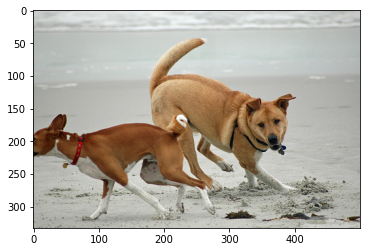

Captions for the image:
Two different breeds of brown and white dogs play on the beach .
Two dogs are making a turn on a soft sand beach .
Two dogs playing in the sand at the beach .
Two dogs playing together on a beach .
Two large tan dogs play along a sandy beach .


In [13]:

df.head()
def visualize_image_and_captions(index: int) -> None:
    """
    Visualize the image and all its captions for a given index in the dataframe.

    Parameters:
    index (int): The index of the dataframe row to visualize.

    Returns:
    None
    """
    # Get the image path and captions for the given index
    img_path = df.loc[index, 'Path']
    captions = df.loc[df['Path'] == img_path, 'Captions'].values

    # Display the image
    visualize_image(img_path)

    # Print all the captions
    print("Captions for the image:")
    for caption in captions:
        print(caption)

# Example usage
visualize_image_and_captions(100)

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters.
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

### Create the tokenizer

In [14]:
# create the tokenizer

top_k = 5000
filter_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=top_k, oov_token='UNK', filters=filter_chars)

tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)
print(train_seqs[:5])
print(annotations[:5])
print('Out of Vocabulary(OOV) token:', tokenizer.oov_token)

# your code here

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4], [3, 2, 20, 317, 65, 2, 197, 118, 4], [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4], [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4], [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]
['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A girl going into a wooden building . <end>', '<start> A little girl climbing into a wooden playhouse . <end>', '<start> A little girl climbing the stairs to her playhouse . <end>', '<start> A little girl in a pink dress going into a wooden cabin . <end>']
Out of Vocabulary(OOV) token: UNK


In [15]:
# Create word-to-index and index-to-word mappings.

word_to_index = tokenizer.word_index
index_to_word = tokenizer.index_word


tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# save tokenizer

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

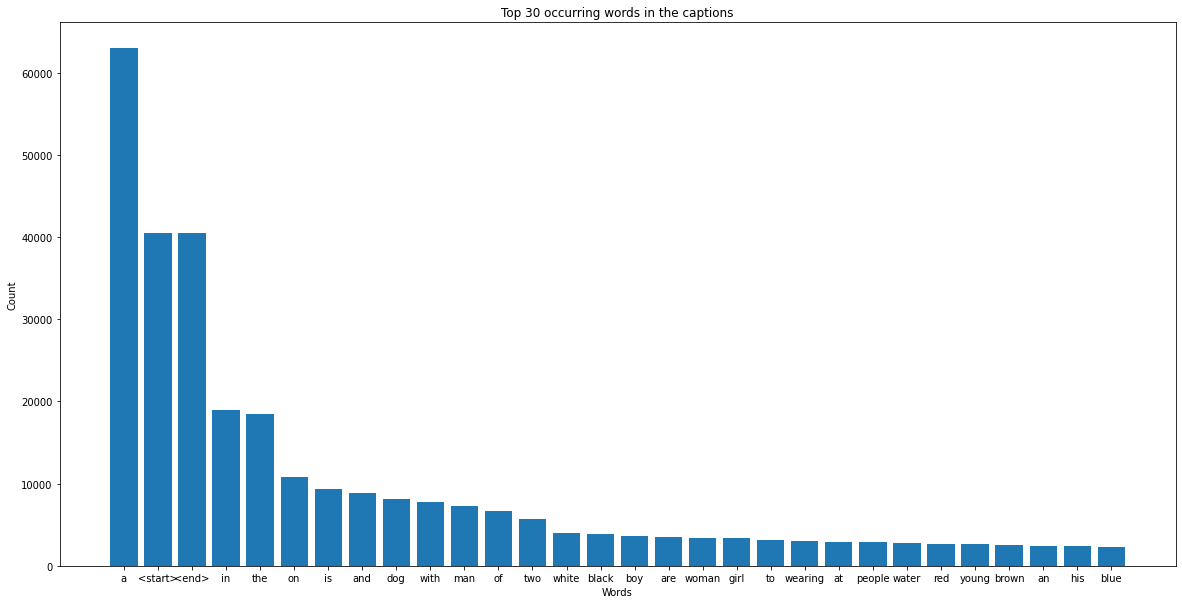

In [16]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
top_token_counter = Counter(tokenizer.word_counts)
plot_top_words(top_token_counter)
# your code here

In [17]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

max_sequence_length = max([len(seq) for seq in train_seqs])
print("The maximum sequence length is: " + str(max_sequence_length))

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(
    train_seqs, padding='post', maxlen=max_sequence_length)

# your code here

print("The shape of Caption vector is :" + str(cap_vector.shape))

The maximum sequence length is: 39
The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image.
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [18]:
# write your code here to create the dataset consisting of image paths

In [19]:
# write your code here for creating the function. This function should return images & their path

def load_image(image_path: str) -> tuple:
    """
    Load and preprocess an image from the specified file path.

    Parameters:
    image_path (str): The file path to the image to be loaded.

    Returns:
    tuple: A tuple containing the preprocessed image tensor and the original image path.
    """
    # Read the image file
    img = tf.io.read_file(image_path)

    # Decode the image as a JPEG file, specifying 3 color channels (RGB)
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize the image to 299x299 pixels
    img = tf.image.resize(img, (299, 299))

    # Preprocess the image using InceptionV3 preprocessing
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    return img, image_path


print("The shape of the image is: " +
      str(load_image(all_img_path[0])[0].shape))

The shape of the image is: (299, 299, 3)


2024-10-21 02:11:59.877370: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-10-21 02:11:59.877450: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3d:00.0, compute capability: 7.5


In [20]:
# write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

batch_size = 16
unique_img_path = sorted(set(all_img_path))
image_dataset = tf.data.Dataset.from_tensor_slices(unique_img_path)
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)
image_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048.

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [21]:
image_model = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet')

new_input = image_model.input  # write code here to get the input of the image_model
# write code here to get the output of the image_model
hidden_layer = image_model.layers[-1].output

# build the final model using both input & output layer
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [22]:

image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [23]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

feature_dict = {}
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(
        batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # your code here to store the features
        # np.save(path_of_feature, bf.numpy())
        feature_dict[path_of_feature] = bf.numpy()

100%|██████████| 506/506 [01:01<00:00,  8.29it/s]


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature.

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [24]:
# write your code here

path_train, path_test, cap_train, cap_test = train_test_split(
    all_img_path, cap_vector, test_size=.2, random_state=42)  # your code goes here)

In [25]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [26]:
# Create a function which maps the image path to their feature.
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(img: bytes, caption: str) -> tuple:
    """
    Load image features from a .npy file and return them along with the caption.

    Parameters:
    img (bytes): The file path to the image, encoded as bytes.
    caption (str): The caption associated with the image.

    Returns:
    tuple: A tuple containing the image tensor and the caption.
    """
    # Decode the image file path from bytes to string and load the .npy file
    # img_tensor = np.load(img.decode('utf-8') + '.npy')
    img_tensor = feature_dict[img.decode('utf-8')]

    return img_tensor, caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [27]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

# your input variables):
def gen_dataset(image: list, caption: list, batch_size: int = 32, buffer_size: int = 1000) -> tf.data.Dataset:
    """
    Generate a TensorFlow dataset from images and captions, applying transformations.

    Parameters:
    image (list): A list of image file paths.
    caption (list): A list of captions corresponding to the images.
    batch_size (int): The size of the batches to be generated. Default is 32.
    buffer_size (int): The buffer size for shuffling the dataset. Default is 1000.

    Returns:
    tf.data.Dataset: A TensorFlow dataset containing the images and captions, with applied transformations.
    """
    # Create a dataset from the image and caption tensors
    dataset = tf.data.Dataset.from_tensor_slices((image, caption))

    # Map the dataset using the map_func to load image features and process captions
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [
                          tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Shuffle the dataset with the specified buffer size
    dataset = dataset.shuffle(buffer_size).batch(batch_size)

    # Prefetch the dataset to improve performance
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [28]:

BATCH_SIZE = 64
train_dataset = gen_dataset(path_train, cap_train, BATCH_SIZE)
test_dataset = gen_dataset(path_test, cap_test, BATCH_SIZE)

In [29]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  # (batch_size, 8*8, 2048)
print(sample_cap_batch.shape)  # (batch_size,max_len)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [30]:
embedding_dim = 256
units = 512
vocab_size = 5001  # top 5,000 words +1
# len(total train images) // BATCH_SIZE
train_num_steps = len(path_train) // BATCH_SIZE
# len(total test images) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

### Encoder

In [31]:
class Encoder(tf.keras.Model):
    """
    Encoder class that processes image features using a Dense layer with ReLU activation.

    Attributes:
    embed_dim (int): The dimensionality of the embedding space.

    Methods:
    call(features): Applies the Dense layer and ReLU activation to the input features.
    """

    def __init__(self, embed_dim: int):
        """
        Initializes the Encoder with a Dense layer.

        Parameters:
        embed_dim (int): The dimensionality of the embedding space.
        """
        super(Encoder, self).__init__()
        # Build your Dense layer with relu activation
        self.dense = tf.keras.layers.Dense(embed_dim)

    def call(self, features: tf.Tensor) -> tf.Tensor:
        """
        Applies the Dense layer and ReLU activation to the input features.

        Parameters:
        features (tf.Tensor): The input features tensor with shape (batch, 8*8, embed_dim).

        Returns:
        tf.Tensor: The processed features tensor with shape (batch, 8*8, embed_dim).
        """
        # Extract the features from the image shape: (batch, 8*8, embed_dim)
        features = self.dense(features)
        features = tf.nn.relu(features)
        return features

In [32]:
encoder = Encoder(embedding_dim)

### Attention model

In [33]:
class Attention_model(tf.keras.Model):
    """
    Attention model class that computes attention weights and context vectors.

    Attributes:
    W1 (tf.keras.layers.Dense): Dense layer for processing features.
    W2 (tf.keras.layers.Dense): Dense layer for processing hidden states.
    V (tf.keras.layers.Dense): Final Dense layer to compute attention scores.
    units (int): The number of units in the Dense layers.

    Methods:
    call(features, hidden): Computes the context vector and attention weights.
    """

    def __init__(self, units: int):
        """
        Initializes the Attention_model with Dense layers.

        Parameters:
        units (int): The number of units in the Dense layers.
        """
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)  # Dense layer for features
        self.W2 = tf.keras.layers.Dense(units)  # Dense layer for hidden states
        # Final Dense layer to compute attention scores
        self.V = tf.keras.layers.Dense(1)
        self.units = units

    def call(self, features: tf.Tensor, hidden: tf.Tensor) -> tuple:
        """
        Computes the context vector and attention weights.

        Parameters:
        features (tf.Tensor): The input features tensor with shape (batch_size, 8*8, embedding_dim).
        hidden (tf.Tensor): The hidden state tensor with shape (batch_size, hidden_size).

        Returns:
        tuple: A tuple containing the context vector (tf.Tensor) with shape (batch_size, embedding_dim)
               and the attention weights (tf.Tensor) with shape (batch_size, 8*8, 1).
        """
        # Expand the hidden shape to (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # Compute the attention hidden layer
        attention_hidden_layer = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))

        # Compute the attention scores
        score = self.V(attention_hidden_layer)

        # Compute the attention weights
        attention_weights = tf.nn.softmax(score, axis=1)

        # Compute the context vector
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### Decoder

In [34]:
class Decoder(tf.keras.Model):
    """
    Decoder class that generates captions from image features using an attention mechanism.

    Attributes:
    units (int): The number of units in the GRU and Dense layers.
    attention (Attention_model): The attention model to compute context vectors.
    embed (tf.keras.layers.Embedding): The embedding layer for input tokens.
    gru (tf.keras.layers.GRU): The GRU layer for sequence processing.
    d1 (tf.keras.layers.Dense): The first Dense layer for processing GRU outputs.
    d2 (tf.keras.layers.Dense): The second Dense layer for generating vocabulary scores.

    Methods:
    call(x, features, hidden): Generates the output and hidden state for a given input and image features.
    init_state(batch_size): Initializes the hidden state for the GRU.
    """

    def __init__(self, embed_dim: int, units: int, vocab_size: int):
        """
        Initializes the Decoder with embedding, GRU, and Dense layers.

        Parameters:
        embed_dim (int): The dimensionality of the embedding space.
        units (int): The number of units in the GRU and Dense layers.
        vocab_size (int): The size of the vocabulary.
        """
        super(Decoder, self).__init__()
        self.units = units
        # Initialize the Attention model with units
        self.attention = Attention_model(self.units)
        # Build the Embedding layer
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)
        # Build the GRU layer
        self.gru = tf.keras.layers.GRU(
            self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        # Build the first Dense layer
        self.d1 = tf.keras.layers.Dense(self.units)
        # Build the second Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)

    def call(self, x: tf.Tensor, features: tf.Tensor, hidden: tf.Tensor) -> tuple:
        """
        Generates the output and hidden state for a given input and image features.

        Parameters:
        x (tf.Tensor): The input tensor with shape (batch_size, 1).
        features (tf.Tensor): The image features tensor with shape (batch_size, 8*8, embedding_dim).
        hidden (tf.Tensor): The hidden state tensor with shape (batch_size, hidden_size).

        Returns:
        tuple: A tuple containing the output tensor (tf.Tensor) with shape (batch_size, vocab_size),
               the hidden state tensor (tf.Tensor) with shape (batch_size, hidden_size),
               and the attention weights tensor (tf.Tensor) with shape (batch_size, 8*8, 1).
        """
        # Create the context vector and attention weights from the attention model
        context_vector, attention_weights = self.attention(features, hidden)
        # Embed the input to shape: (batch_size, 1, embedding_dim)
        embed = self.embed(x)
        # Concatenate the input with the context vector from the attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        # Extract the output and hidden state from the GRU layer. Output shape: (batch_size, max_length, hidden_size)
        output, state = self.gru(embed)
        output = self.d1(output)
        # Reshape the output to shape: (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        # Generate the final output with shape: (batch_size * max_length, vocab_size)
        output = self.d2(output)

        return output, state, attention_weights

    def init_state(self, batch_size: int) -> tf.Tensor:
        """
        Initializes the hidden state for the GRU.

        Parameters:
        batch_size (int): The size of the batch.

        Returns:
        tf.Tensor: A tensor of zeros with shape (batch_size, units).
        """
        return tf.zeros((batch_size, self.units))

In [35]:
decoder = Decoder(embedding_dim, units, vocab_size)

In [36]:
features = encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims(
    [tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights = decoder(
    dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(
    features.shape))  # (batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(
    predictions.shape))  # (batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(
    attention_weights.shape))  # (batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [37]:
optimizer = tf.keras.optimizers.Adam()  # define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')  # define your loss object

In [38]:
def loss_function(real: tf.Tensor, pred: tf.Tensor) -> tf.Tensor:
    """
    Computes the masked loss between the real and predicted values.

    Parameters:
    real (tf.Tensor): The ground truth tensor with shape (batch_size, sequence_length).
    pred (tf.Tensor): The predicted tensor with shape (batch_size, sequence_length, vocab_size).

    Returns:
    tf.Tensor: The computed loss value.
    """
    # Create a mask to ignore the padding (0) values in the real tensor
    mask = tf.math.logical_not(tf.math.equal(real, 0))

    # Compute the loss between the real and predicted values
    loss_ = loss_object(real, pred)

    # Cast the mask to the same dtype as the loss
    mask = tf.cast(mask, dtype=loss_.dtype)

    # Apply the mask to the loss
    loss_ *= mask

    # Return the mean loss
    return tf.reduce_mean(loss_)

In [39]:
checkpoint_path = "checkpoints/train"

ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [40]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [41]:
@tf.function
def train_step(img_tensor: tf.Tensor, target: tf.Tensor) -> tuple:
    """
    Performs a single training step for the image captioning model.

    Parameters:
    img_tensor (tf.Tensor): The input image tensor with shape (batch_size, height, width, channels).
    target (tf.Tensor): The target caption tensor with shape (batch_size, sequence_length).

    Returns:
    tuple: A tuple containing the total loss and the average loss for the training step.
    """
    loss = 0
    # Initialize the hidden state of the decoder
    hidden = decoder.init_state(batch_size=target.shape[0])
    # Prepare the initial decoder input with the <start> token
    dec_input = tf.expand_dims(
        [tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        # Extract features from the image using the encoder
        features = encoder(img_tensor)
        # Iterate over the target sequence length
        for i in range(1, target.shape[1]):
            # Generate predictions using the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            # Compute the loss for the current time step
            loss += loss_function(target[:, i], predictions)
            # Use teacher forcing: set the next decoder input to the current target token
            dec_input = tf.expand_dims(target[:, i], 1)

        # Compute the average loss
        avg_loss = loss / int(target.shape[1])
        # Get the trainable variables of the encoder and decoder
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        # Compute the gradients of the loss with respect to the trainable variables
        gradients = tape.gradient(loss, trainable_variables)
        # Apply the gradients to the optimizer
        optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss
# * While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [42]:
@tf.function
def test_step(img_tensor: tf.Tensor, target: tf.Tensor) -> tuple:
    """
    Performs a single test step for the image captioning model.

    Parameters:
    img_tensor (tf.Tensor): The input image tensor with shape (batch_size, height, width, channels).
    target (tf.Tensor): The target caption tensor with shape (batch_size, sequence_length).

    Returns:
    tuple: A tuple containing the total loss and the average loss for the test step.
    """
    loss = 0
    # Initialize the hidden state of the decoder
    hidden = decoder.init_state(batch_size=target.shape[0])
    # Prepare the initial decoder input with the <start> token
    dec_input = tf.expand_dims(
        [tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        # Extract features from the image using the encoder
        features = encoder(img_tensor)
        # Iterate over the target sequence length
        for i in range(1, target.shape[1]):
            # Generate predictions using the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            # Compute the loss for the current time step
            loss += loss_function(target[:, i], predictions)
            # Get the predicted token ID
            predicted_id = tf.argmax(predictions, 1)
            # Set the next decoder input to the predicted token
            dec_input = tf.expand_dims(predicted_id, 1)

    # Compute the average loss
    avg_loss = loss / int(target.shape[1])

    return loss, avg_loss

In [43]:
def test_loss_cal(test_dataset: tf.data.Dataset) -> tf.Tensor:
    """
    Calculates the average loss on the test dataset.

    Parameters:
    test_dataset (tf.data.Dataset): The test dataset containing image tensors and target captions.

    Returns:
    tf.Tensor: The average loss on the test dataset.
    """
    total_loss = 0

    # Iterate over the test dataset
    for batch, (img_tensor, target) in enumerate(test_dataset):
        # Perform a test step and get the batch loss
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss

    # Compute the average test loss
    avg_test_loss = total_loss / test_num_steps
    return avg_test_loss

In [44]:
# ## Model Training

In [45]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss = 100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss = total_loss / train_num_steps

    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(
        epoch+1, avg_train_loss, test_loss))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' %
              (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.269, & test loss is 1.941
Time taken for 1 epoch 199.61706376075745 sec

Test loss has been reduced from 100.000 to 1.941


  7%|▋         | 1/15 [03:19<46:38, 199.88s/it]

For epoch: 2, the train loss is 0.988, & test loss is 1.924
Time taken for 1 epoch 92.67136120796204 sec

Test loss has been reduced from 1.941 to 1.924


 20%|██        | 3/15 [06:24<23:14, 116.21s/it]

For epoch: 3, the train loss is 0.899, & test loss is 1.927
Time taken for 1 epoch 91.4935142993927 sec



 27%|██▋       | 4/15 [07:59<19:48, 108.01s/it]

For epoch: 4, the train loss is 0.836, & test loss is 1.928
Time taken for 1 epoch 95.4371120929718 sec



 33%|███▎      | 5/15 [09:34<17:12, 103.28s/it]

For epoch: 5, the train loss is 0.785, & test loss is 1.952
Time taken for 1 epoch 94.88921284675598 sec



 40%|████      | 6/15 [11:07<14:57, 99.76s/it] 

For epoch: 6, the train loss is 0.740, & test loss is 1.936
Time taken for 1 epoch 92.90266156196594 sec



 47%|████▋     | 7/15 [12:39<12:57, 97.16s/it]

For epoch: 7, the train loss is 0.699, & test loss is 2.017
Time taken for 1 epoch 91.81992864608765 sec



 53%|█████▎    | 8/15 [14:15<11:16, 96.68s/it]

For epoch: 8, the train loss is 0.661, & test loss is 2.029
Time taken for 1 epoch 95.64383316040039 sec



 60%|██████    | 9/15 [15:51<09:40, 96.70s/it]

For epoch: 9, the train loss is 0.626, & test loss is 2.058
Time taken for 1 epoch 96.73437166213989 sec



 67%|██████▋   | 10/15 [17:19<07:49, 93.85s/it]

For epoch: 10, the train loss is 0.593, & test loss is 2.118
Time taken for 1 epoch 87.44952940940857 sec



 73%|███████▎  | 11/15 [18:49<06:10, 92.69s/it]

For epoch: 11, the train loss is 0.562, & test loss is 2.216
Time taken for 1 epoch 90.06516289710999 sec



 80%|████████  | 12/15 [20:18<04:35, 91.76s/it]

For epoch: 12, the train loss is 0.534, & test loss is 2.289
Time taken for 1 epoch 89.62261915206909 sec



 87%|████████▋ | 13/15 [21:55<03:06, 93.17s/it]

For epoch: 13, the train loss is 0.506, & test loss is 2.378
Time taken for 1 epoch 96.41451001167297 sec



 93%|█████████▎| 14/15 [23:29<01:33, 93.44s/it]

For epoch: 14, the train loss is 0.481, & test loss is 2.425
Time taken for 1 epoch 94.06412839889526 sec



100%|██████████| 15/15 [25:02<00:00, 100.17s/it]

For epoch: 15, the train loss is 0.457, & test loss is 2.521
Time taken for 1 epoch 93.13056063652039 sec



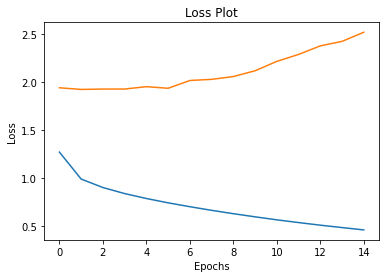

In [46]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE:
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not.
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model.

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [47]:


attention_features_shape = 64


def evaluate(image: str, max_sequence_len: int, attention_features_shape: int) -> tuple:
    """
    Evaluates an image and generates a caption using the trained image captioning model.

    Parameters:
    image (str): The file path to the image to be evaluated.
    max_sequence_len (int): The maximum length of the generated caption sequence.
    attention_features_shape (int): The shape of the attention features.

    Returns:
    tuple: A tuple containing the generated caption (list of words), the attention plot (numpy array),
           and the predictions (tf.Tensor).
    """
    # Initialize the attention plot with zeros
    attention_plot = np.zeros((max_sequence_len, attention_features_shape))

    # Initialize the hidden state of the decoder
    hidden = decoder.init_state(batch_size=1)

    # Process the input image to the desired format before extracting features
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    # Extract features using the feature extraction model
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # Extract the features by passing the input to the encoder
    features = encoder(img_tensor_val)

    # Prepare the initial decoder input with the <start> token
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_sequence_len):
        # Get the output from the decoder
        predictions, hidden, attention_weights = decoder(
            dec_input, features, hidden)

        # Store the attention weights for the current time step
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # Extract the predicted id (embedded value) which carries the max value
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        # Map the id to the word from the tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        # If the predicted word is the end token, return the result
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot, predictions

        # Set the next decoder input to the predicted id
        dec_input = tf.expand_dims([predicted_id], 0)

    # Trim the attention plot to the length of the result
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions

### Beam Search(optional)

In [48]:
def beam_evaluate(image: str, beam_index: int = 3) -> str:
    """
    Evaluates an image and generates a caption using beam search.

    Parameters:
    image (str): The file path to the image to be evaluated.
    beam_index (int): The beam width for beam search. Default is 3.

    Returns:
    str: The generated caption for the image.
    """
    # Initialize the start token and result list
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    # Initialize the attention plot with zeros
    attention_plot = np.zeros((max_sequence_length, attention_features_shape))

    # Initialize the hidden state of the decoder
    hidden = decoder.init_state(batch_size=1)

    # Process the input image to the desired format before extracting features
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # Extract the features by passing the input to the encoder
    features = encoder(img_tensor_val)

    # Prepare the initial decoder input with the <start> token
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_sequence_length:
        temp = []
        for i, s in enumerate(result):
            # Get the output from the decoder
            predictions, hidden, attention_weights = decoder(
                dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            # Get the top beam_index predictions
            word_preds = np.argsort(predictions[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += np.log(predictions[0][w])
                temp.append([next_cap, prob])

        # Sort and select the top beam_index results
        result = sorted(temp, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]

        predicted_id = result[-1]
        pred_list = predicted_id[0]
        prd_id = pred_list[-1]

        if prd_id != tokenizer.word_index['<end>']:
            dec_input = tf.expand_dims([prd_id], 0)
        else:
            break

    result2 = result[-1][0]

    # Convert the token IDs to words
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

a man in a woman in a woman in a woman in a woman in a woman in a woman in a woman in a woman in a woman in a woman in a woman in a woman


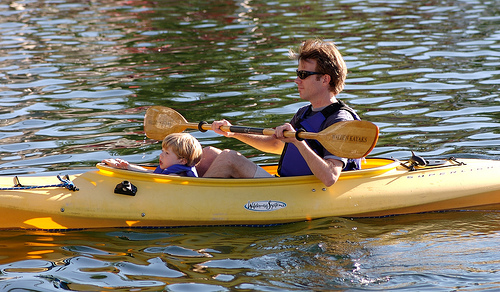

In [49]:


test_image = './images/1028205764_7e8df9a2ea.jpg'
captions = beam_evaluate(test_image)
print(captions)
Image.open(test_image)

In [50]:
def plot_attmap(caption: list, weights: np.ndarray, image: str) -> None:
    """
    Plots the attention map for each word in the caption on the given image.

    Parameters:
    caption (list): A list of words in the caption.
    weights (np.ndarray): A numpy array of attention weights with shape (len(caption), 64).
    image (str): The file path to the image.

    Returns:
    None
    """
    # Create a figure with specified size
    fig = plt.figure(figsize=(10, 10))
    # Load the image and convert it to a numpy array
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        # Reshape the attention weights to 8x8 and resize to 224x224
        weights_img = np.reshape(weights[cap], (8, 8))
        weights_img = np.array(Image.fromarray(
            weights_img).resize((224, 224), Image.LANCZOS))

        # Add a subplot for each word in the caption
        ax = fig.add_subplot(len_cap // 2, len_cap // 2, cap + 1)
        ax.set_title(caption[cap], fontsize=15)

        # Display the image
        img = ax.imshow(temp_img)

        # Overlay the attention map on the image
        ax.imshow(weights_img, cmap='gist_heat',
                  alpha=0.6, extent=img.get_extent())
        ax.axis('off')

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    # Show the plot
    plt.show()

In [51]:
def filt_text(text: str) -> str:
    """
    Filters out specific tokens from the text.

    Parameters:
    text (str): The input text to be filtered.

    Returns:
    str: The filtered text.
    """
    # List of tokens to be filtered out
    filt = ['<start>', '<unk>', '<end>']
    # Split the text into words
    temp = text.split()
    # Remove the specified tokens from the text
    [temp.remove(j) for k in filt for j in temp if k == j]
    # Join the words back into a single string
    text = ' '.join(temp)
    return text

/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

BELU score: 15.0
Real Caption: a girl wearing shorts plays jump rope
Prediction Caption: a little girl and a long pink striped shirt jumping over a rope and is standing in a grassy area


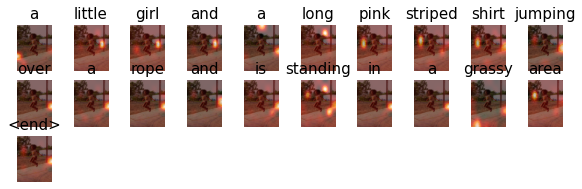

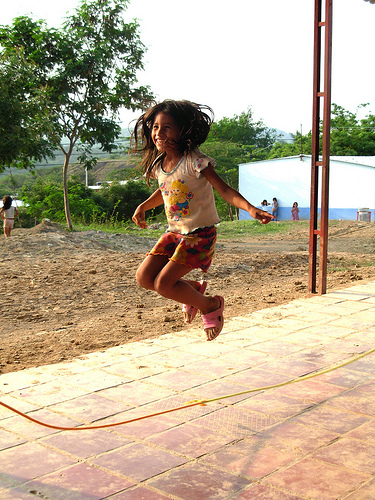

In [52]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_test[rid] if i not in [0]])
result, attention_plot, pred_test = evaluate(
    test_image, max_sequence_length, attention_features_shape)


real_caption = filt_text(real_caption)


pred_caption = ' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

# set your weights)
score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [53]:
print(pred_caption)

soundfile = "pred_caption.mp3"
tts = gTTS(pred_caption)
tts.save(soundfile)

Audio(soundfile, autoplay=True)

a little girl and a long pink striped shirt jumping over a rope and is standing in a grassy area


In [54]:
captions = beam_evaluate(test_image)
print(captions)

a young is pink striped rope


Predicted Caption: a black and black dog playing in water
Image:


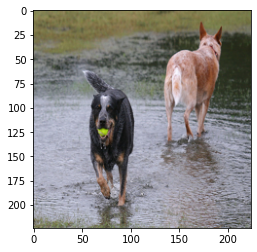

a black and black dog playing in water


In [55]:


def predict_unknown_data(image_path: str) -> str:
    """
    Generates a caption for an unknown image and displays the image with the predicted caption.

    Parameters:
    image_path (str): The file path to the image to be evaluated.

    Returns:
    str: The predicted caption for the image.
    """
    # Open the image from the given file path
    openImage = Image.open(image_path)

    # Evaluate the image to generate a caption and attention plot
    result, attention_plot, pred_test = evaluate(
        image_path, max_sequence_length, attention_features_shape)

    # Join the result to form the predicted caption and remove the last word
    pred_caption = ' '.join(result).rsplit(' ', 1)[0]

    # Split the predicted caption into individual words
    candidate = pred_caption.split()

    # Print the predicted caption
    print('Predicted Caption:', pred_caption)
    print('Image:')

    # Resize the image to 224x224 pixels
    newsize = (224, 224)
    openImage = openImage.resize(newsize)

    # Display the image
    plt.imshow(openImage)
    plt.show()

    return pred_caption


unknown_data_caption = predict_unknown_data(path_test[59])
print(unknown_data_caption)

def predict_and_autoplay(image_path: str) -> None:
    """
    Generates a caption for an unknown image and displays the image with the predicted caption.

    Parameters:
    image_path (str): The file path to the image to be evaluated.

    Returns:
    None
    """
    # Generate the predicted caption for the unknown image
    unknown_data_caption = predict_unknown_data(image_path)
    
    # Create a temporary file to save the audio
    with tempfile.NamedTemporaryFile(suffix=".mp3", delete=False) as temp_audio_file:
        soundfile = temp_audio_file.name
        # Save the predicted caption as an audio file
        tts = gTTS(unknown_data_caption)
        tts.save(soundfile)

    # Play the audio file
    Audio(soundfile, autoplay=True)

Predicted Caption: a boy in a red shirt and a white cap is walking on a street with handicap signs
Image:


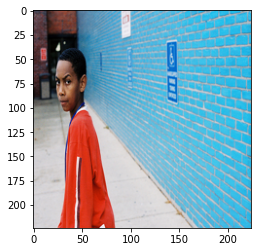

In [ ]:
predict_and_autoplay(path_test[90])

Predicted Caption: a biker jumping his bike down a grassy hill
Image:


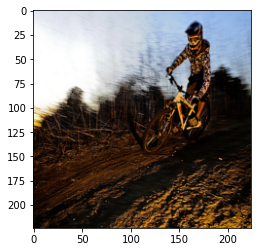

In [61]:
predict_and_autoplay(path_test[30])